# Easier navigation:

------------------------------------
## 0. <a href='#col'>Columns</a>
## 1. <a href='#setup'>Setup</a>
------------------------------------
## 2. <a href='#pca'>PCA</a>
## 3. <a href='#a'>Fixed Entry Feature Investigation</a>
## 4. <a href='#b'>Variable Entry Feature Investigation</a>
## 5. <a href='#c'>Other</a>

<a name='col'></a>
# 0. Columns

0. Timestamp
1. How many units are you currently taking?
2. How old are you?
3. What's your major? ("n/a" if not applicable, otherwise capitalize first letter, ex. "Biology")
4. On a scale from 1 to 10 how productive do you think you were today?  
5. How many assignments/tasks have you accomplished today? (Give in the form of a fraction or percentage)
6. What is your average daily screen time?  (hours)
7. What are the top apps used
8. What social media platforms do you use the most? 
9. How much in total daily? weekly?
10. Are you listening to anything right now? 
11. What music genre do you prefer to listen to?
12. In general are you an athletic/fit person? 
13. How many hours did you spend exercising today?
14. How many times did you exercise this week?
15. Do you try to stay fit? 
16. Why do you exercise? 
17. How much do you drink on average each time? (# of drinks)
18. When was the last time you consumed an alcoholic beverage?
19. Why do you drink?
20. How much sleep did you get last night? 
21. How much sleep do you get on average? 
22. How much sleep do you wish to get on average?
23. Do you take naps regularly? 
24. What is the date?
25. What is the time right now? 
26. On a scale of 1 to 10, how stressed do you feel right now?
27. On a scale of 1 to 10, how stressed have you been on average in the past 6 months?
28. Are you a vegetarian/vegan? 
29. Do you have any dietary restrictions?
30. Number Memory
31. Sequence Memory
32. Visual Memory
33. Memory Sum

<a name='setup'></a>
# 1. Setting up table

Given that we only have ~50 entries, it'd probably be easier to manually edit bad entries than to have to correct it using regex, etc.

A lot of free response columns don't seem very useful, but if you want to investigate it you can edit the data to fit a certain form.

In [20]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
sns.set()
plt.style.use('fivethirtyeight')
import zipfile
import os # Used to interact with the file system
import re
from copy import deepcopy
from tabulate import tabulate
import plotly.express as px

import sklearn
import sklearn.datasets
import sklearn.linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model as lm
from sklearn.feature_extraction import DictVectorizer
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')
# Note: If you're having problems with the 3d scatter plots, uncomment the two␣
#,→lines below, and you should see a version that
# number that is at least 4.1.1.
# import plotly
# plotly.__version__


In [2]:
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
service = build('drive', 'v3')

In [3]:
# Run this to mount the Notebook in your Google Drive account 
from google.colab import drive
#drive.mount('/content/drive')
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Specify path for CSV file.

In [4]:
path = "/content/drive/My Drive/CogSci C100/Cog Group Project/Cogsci100SampleSurvey.csv"

In [5]:
df = pd.read_csv(path)
df.head()

,Timestamp,How many units are you currently taking?,How old are you?,"What's your major? (""n/a"" if not applicable, otherwise capitalize first letter, ex. ""Biology"")",On a scale from 1 to 10 how productive do you think you were today?,How many assignments/tasks have you accomplished today? (Give in the form of a fraction or percentage),What is your average daily screen time? (hours),What are the top apps used,What social media platforms do you use the most?,How much in total daily? weekly?,Are you listening to anything right now?,What music genre do you prefer to listen to?,In general are you an athletic/fit person?,How many hours did you spend exercising today?,How many times did you exercise this week?,Do you try to stay fit?,Why do you exercise?,How much do you drink on average each time? (# of drinks),When was the last time you consumed an alcoholic beverage?,Why do you drink?,How much sleep did you get last night?,How much sleep do you get on average?,How much sleep do you wish to get on average?,Do you take naps regularly?,What is the date?,What is the time right now?,"On a scale of 1 to 10, how stressed do you feel right now?","On a scale of 1 to 10, how stressed have you been on average in the past 6 months?",Are you a vegetarian/vegan?,Do you have any dietary restrictions?,Number Memory,Sequence Memory,Visual Memory
0,2021/03/17 6:41:47 PM MDT,19,18,Chemistry,8,0.4,6-8,Tiktok and Snapchat,Youtube;Instagram;TikTok;Snapchat,30,Yes,Pop,Yes,0-1 hours,3,Yes,To stay healthy,5-6,Last week,Social,5 - 7 hrs,8 - 10 hrs,8 - 10 hrs,No,2021-03-17,20:41,3,6,No,Nope,10,10,10
1,2021/03/17 6:46:26 PM MDT,16,19,Business,3,0.1,4-6,Tiktok Instagram Netflix,Instagram,35 minutes daily 5 hour weekly,Yes,EDM,Yes,0-1 hours,5,Yes,For myself looks health,7+,Last month,it’s enjoyable,5 - 7 hrs,5 - 7 hrs,8 - 10 hrs,No,2021-03-17,20:41,8,2,No,Nope,9,8,9
2,2021/03/17 6:52:18 PM MDT,15,19,Health Science,8,0.6,4-6,"TikTok, Instagram",Youtube;Instagram;TikTok;Snapchat,6hr 21min daily. 25hr 27mins weekly,Yes,good music.,No,0-1 hours,2,No,i don’t,1-2,Last 2 days,life feels fuzzy idk,8 - 10 hrs,5 - 7 hrs,8 - 10 hrs,No,2021-03-17,20:47,9,10,No,milk in the morning makes me doodoo,8,6,11
3,2021/03/17 6:58:38 PM MDT,17,19,Computer Science,7,NaN,6-8,"YouTube, Messenger, Chrome",Youtube;Messenger,"3, 20",No,Electronic,No,1-2 hours,4,Yes,Health,1-2,Last week,Escape the pain,5 - 7 hrs,5 - 7 hrs,8 - 10 hrs,Yes,2021-03-17,20:56,7,8,No,No,11,9,9
4,2021/03/17 7:04:52 PM MDT,16,20,Business Admin & Econ,5,0.5,4-6,"Instagram, Tiktok",Facebook;Youtube;Instagram;TikTok;Snapchat;Dis...,"6 daily, 48 weekly",No,"Rap, EDM",Yes,0-1 hours,5,Yes,To stay slim and athletic,7+,Last 2 days,To have fun and release,5 - 7 hrs,8 - 10 hrs,8 - 10 hrs,No,2021-03-17,14:56,8,6,No,Nope,10,16,11


In [6]:
from pprint import pprint
ctt = 0
for i in df.columns:
  #print(str(ctt) + ". " + i)
  ctt += 1

In [7]:
dict={}
for i in np.arange(33):
  dict[i] = df.columns[i]
df = df.rename(columns={x:y for x,y in zip(df.columns,range(0,len(df.columns)))})
df[33] = df[30] + df[31] + df[32]
dict[33] = "Memory Sum"
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,2021/03/17 6:41:47 PM MDT,19,18,Chemistry,8,0.4,6-8,Tiktok and Snapchat,Youtube;Instagram;TikTok;Snapchat,30,Yes,Pop,Yes,0-1 hours,3,Yes,To stay healthy,5-6,Last week,Social,5 - 7 hrs,8 - 10 hrs,8 - 10 hrs,No,2021-03-17,20:41,3,6,No,Nope,10,10,10,30
1,2021/03/17 6:46:26 PM MDT,16,19,Business,3,0.1,4-6,Tiktok Instagram Netflix,Instagram,35 minutes daily 5 hour weekly,Yes,EDM,Yes,0-1 hours,5,Yes,For myself looks health,7+,Last month,it’s enjoyable,5 - 7 hrs,5 - 7 hrs,8 - 10 hrs,No,2021-03-17,20:41,8,2,No,Nope,9,8,9,26
2,2021/03/17 6:52:18 PM MDT,15,19,Health Science,8,0.6,4-6,"TikTok, Instagram",Youtube;Instagram;TikTok;Snapchat,6hr 21min daily. 25hr 27mins weekly,Yes,good music.,No,0-1 hours,2,No,i don’t,1-2,Last 2 days,life feels fuzzy idk,8 - 10 hrs,5 - 7 hrs,8 - 10 hrs,No,2021-03-17,20:47,9,10,No,milk in the morning makes me doodoo,8,6,11,25
3,2021/03/17 6:58:38 PM MDT,17,19,Computer Science,7,NaN,6-8,"YouTube, Messenger, Chrome",Youtube;Messenger,"3, 20",No,Electronic,No,1-2 hours,4,Yes,Health,1-2,Last week,Escape the pain,5 - 7 hrs,5 - 7 hrs,8 - 10 hrs,Yes,2021-03-17,20:56,7,8,No,No,11,9,9,29
4,2021/03/17 7:04:52 PM MDT,16,20,Business Admin & Econ,5,0.5,4-6,"Instagram, Tiktok",Facebook;Youtube;Instagram;TikTok;Snapchat;Dis...,"6 daily, 48 weekly",No,"Rap, EDM",Yes,0-1 hours,5,Yes,To stay slim and athletic,7+,Last 2 days,To have fun and release,5 - 7 hrs,8 - 10 hrs,8 - 10 hrs,No,2021-03-17,14:56,8,6,No,Nope,10,16,11,37


In [8]:
dict

{0: 'Timestamp',
 1: 'How many units are you currently taking?',
 2: 'How old are you?',
 3: 'What\'s your major? ("n/a" if not applicable, otherwise capitalize first letter, ex. "Biology")',
 4: 'On a scale from 1 to 10 how productive do you think you were today?  ',
 5: 'How many assignments/tasks have you accomplished today? (Give in the form of a fraction or percentage)',
 6: 'What is your average daily screen time?  (hours)',
 7: 'What are the top apps used',
 8: 'What social media platforms do you use the most? ',
 9: 'How much in total daily? weekly?',
 10: 'Are you listening to anything right now? ',
 11: 'What music genre do you prefer to listen to?',
 12: 'In general are you an athletic/fit person? ',
 13: 'How many hours did you spend exercising today?',
 14: 'How many times did you exercise this week?',
 15: 'Do you try to stay fit? ',
 16: 'Why do you exercise? ',
 17: 'How much do you drink on average each time? (# of drinks)',
 18: 'When was the last time you consumed an

# 2. PCA

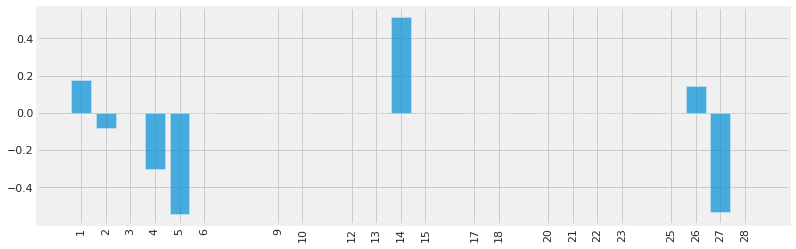

('How many times did you exercise this week?', 0    3
 1    5
 2    2
 3    4
 4    5
 5    2
 6    3
 7    6
 8    0
 Name: 14, dtype: int64)

In [9]:
def pca(df):
  # Center data
  df_mean = df.mean(axis=0)
  df_centered = df - df_mean
  # Scale - each col has unit variance
  df_centered_scaled = df_centered / np.sqrt(np.var(df_centered))
  # for the case where all values are 0, SVD doesn't converge
  df_centered_scaled = df_centered_scaled.fillna(0)
  # Break into components
  #df_centered_scaled.dropna(inplace=True)
  u, s, vt = np.linalg.svd(df_centered_scaled, full_matrices=False)
  v = vt.T
  P = df_centered @ v
  plt.figure(figsize=(12, 4))
  plt.bar(df.columns, vt[0, :], alpha=0.7)
  plt.xticks(df.columns, rotation=90)
  plt.show()
  
  return P

pca(df[[1,2,3,4,5,6,9,10,12,13,14,15,17,18,20,21,22,23,25,26,27,28]])
dict[14], df[14]

<a name='a'></a>
# 3. Fixed Entry Feature Investigation

Picking columns with multiple choice / yes-no answers to compare with memory results

ENTER QUESTION NUMBER HERE

In [10]:
k = 14

#-------------
dict[k]


'How many times did you exercise this week?'

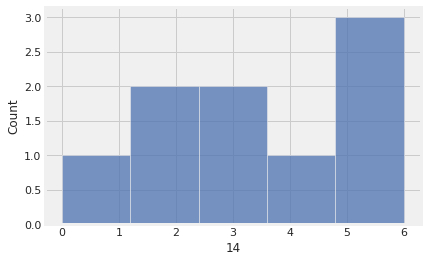

In [11]:
sns.histplot(df[k])

ENTER CUTOFF HERE

In [12]:
cutoff1 = 4

-------------------------------------

In [13]:
df[[k, 30, 31, 32, 33]]

,14,30,31,32,33
0,3,10,10,10,30
1,5,9,8,9,26
2,2,8,6,11,25
3,4,11,9,9,29
4,5,10,16,11,37
5,2,8,8,11,27
6,3,9,6,11,26
7,6,9,6,15,30
8,0,10,12,11,33


Average scores with less than CUTOFF

In [14]:
np.average(df[df[k] < cutoff1][30]), np.average(df[df[k] < cutoff1][31]), np.average(df[df[k] < cutoff1][32]), np.average(df[df[k] < cutoff1][33])

(9.0, 8.4, 10.8, 28.2)

Average scores with more than CUTOFF

In [15]:
np.average(df[df[k] > cutoff1][30]), np.average(df[df[k] > cutoff1][31]), np.average(df[df[k] > cutoff1][32]), np.average(df[df[k] > cutoff1][33])

(9.333333333333334, 10.0, 11.666666666666666, 31.0)

Graphs

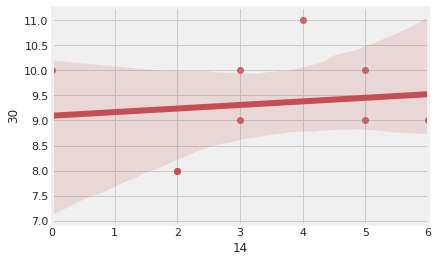

In [16]:
sns.regplot(x=df[k], y=df[30], color="r")


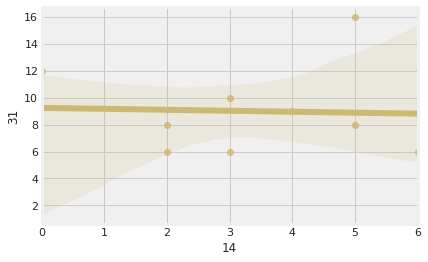

In [17]:
sns.regplot(x=df[k], y=df[31], color="y")

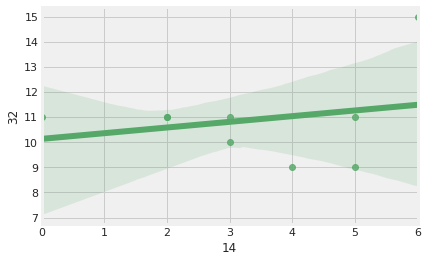

In [18]:
sns.regplot(x=df[k], y=df[32], color="g")

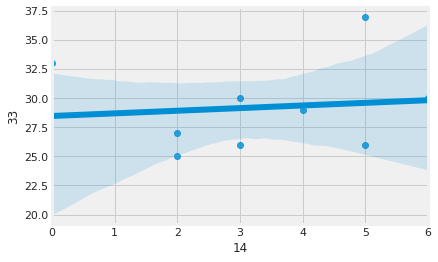

In [19]:
sns.regplot(x=df[k], y=df[33])

<a name='b'></a>
# 4.  Variable Entry Feature Investigation

Picking columns with free response entries to compare with memory results

<a name='c'></a>
# 5. Other

Anything that does not involve memory tests as a comparison